# Compare FracMinHash sketch abundance distributions and gene count distributions

abbreviations:
  + Pa: *Pseudomonas aeruginosa*
  
This notebook looks at FracMinHash k-mer abundance distributions in Pa transcriptomes. The overall goal of this repository is to assess whether FracMinHash sketches can be used as a replacement for gene counts to identify correlations between genes or sequences in a transcriptome. One important step in identifying gene-gene correlations is normalizing gene count data. This notebook looks at FracMinHash k-mer abundance distributions to see if the same techniques can be used to normalize this data as are used to normalize gene count data.

In [1]:
setwd("..")

In [2]:
options(warn=-1) # suppress warnings

In [3]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [5]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)
library(gamlss)

## Read in and format data

### Metadata

In [7]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F)
metadata_pa14 <- metadata %>%
  filter(strain_type == "PA14")
metadata_pao1 <- metadata %>%
  filter(strain_type == "PAO1")

### Raw compendia

In [8]:
# read in raw compendia generated by Doing et al. 
# counts represent the raw NumReads output by pseudomapping each RNAseq library against each reference transcriptome
# code also fixes column names so they only contain SRA experiment accessions

raw_pa14 <- read_csv("https://osf.io/uvpsa/download", show_col_types = F) %>%
  rename(TxName = "...1")
colnames(raw_pa14) <- gsub("\\.salmon", "", basename(colnames(raw_pa14)))

raw_pao1 <- read_csv("https://osf.io/67j4g/download", show_col_types = F) %>%
  rename(TxName = "...1")
colnames(raw_pao1) <- gsub("\\.salmon", "", basename(colnames(raw_pao1)))

New names:
* `` -> ...1

New names:
* `` -> ...1



In [9]:
# Each compendia contains all Pa libraries, so this code block filters each compendia to contain only RNAseq samples
# of a particular strain, as inferred by Lee et al. and recorded in metadata.tsv
raw_pa14_filt <- raw_pa14 %>%
  column_to_rownames("Name") %>%
  dplyr::select(one_of(metadata_pa14$experiment))

raw_pao1_filt <- raw_pao1 %>%
  column_to_rownames("Name") %>%
  dplyr::select(one_of(metadata_pao1$experiment))

In [10]:
dim(raw_pa14_filt)
dim(raw_pao1_filt)

[1] 5891  541

[1] 5563  861

### Raw k-mer abundances

In [20]:
# select only pa14 compendia files for init investigation
# look at first 100 files (vector memory exhausted when reading in all pa14);
# automatically goes from long to wide, which is expensive
pa14_files <- paste0("outputs/srx_sourmash_sketch_filtered_csv/", colnames(raw_pa14_filt), "_k21.csv")
raw_pa14_kmers_long <- pa14_files %>%
  head(n = 100) %>%                          # subset to first 100
  purrr::set_names() %>%
  map_dfr(read_csv, skip = 1, col_names = c("minhash", "abund"), show_col_types = F, .id = "sample") %>%  # read in sketches
  mutate(sample = gsub("_k21\\.csv", "", basename(sample)))

In [25]:
# pivot from long to wide; shares minhash index
raw_pa14_kmers <- raw_pa14_kmers_long %>%
  pivot_wider(id_cols = minhash, names_from = sample, values_from = abund) %>%
  replace(is.na(.), 0)                    # replace NAs with zero abund

In [26]:
raw_pa14_kmers[1:5, 1:5]

minhash,SRX4641866,SRX4641865,SRX4641864,SRX4641863
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6420423175363,3,0,0,2
7037975305246,2,0,6,0
8687411883152,2,0,0,0
12877586329792,15,4,7,0
17768479976268,2,0,0,0


## Plot example distributions

### Plot: example SRX4641866

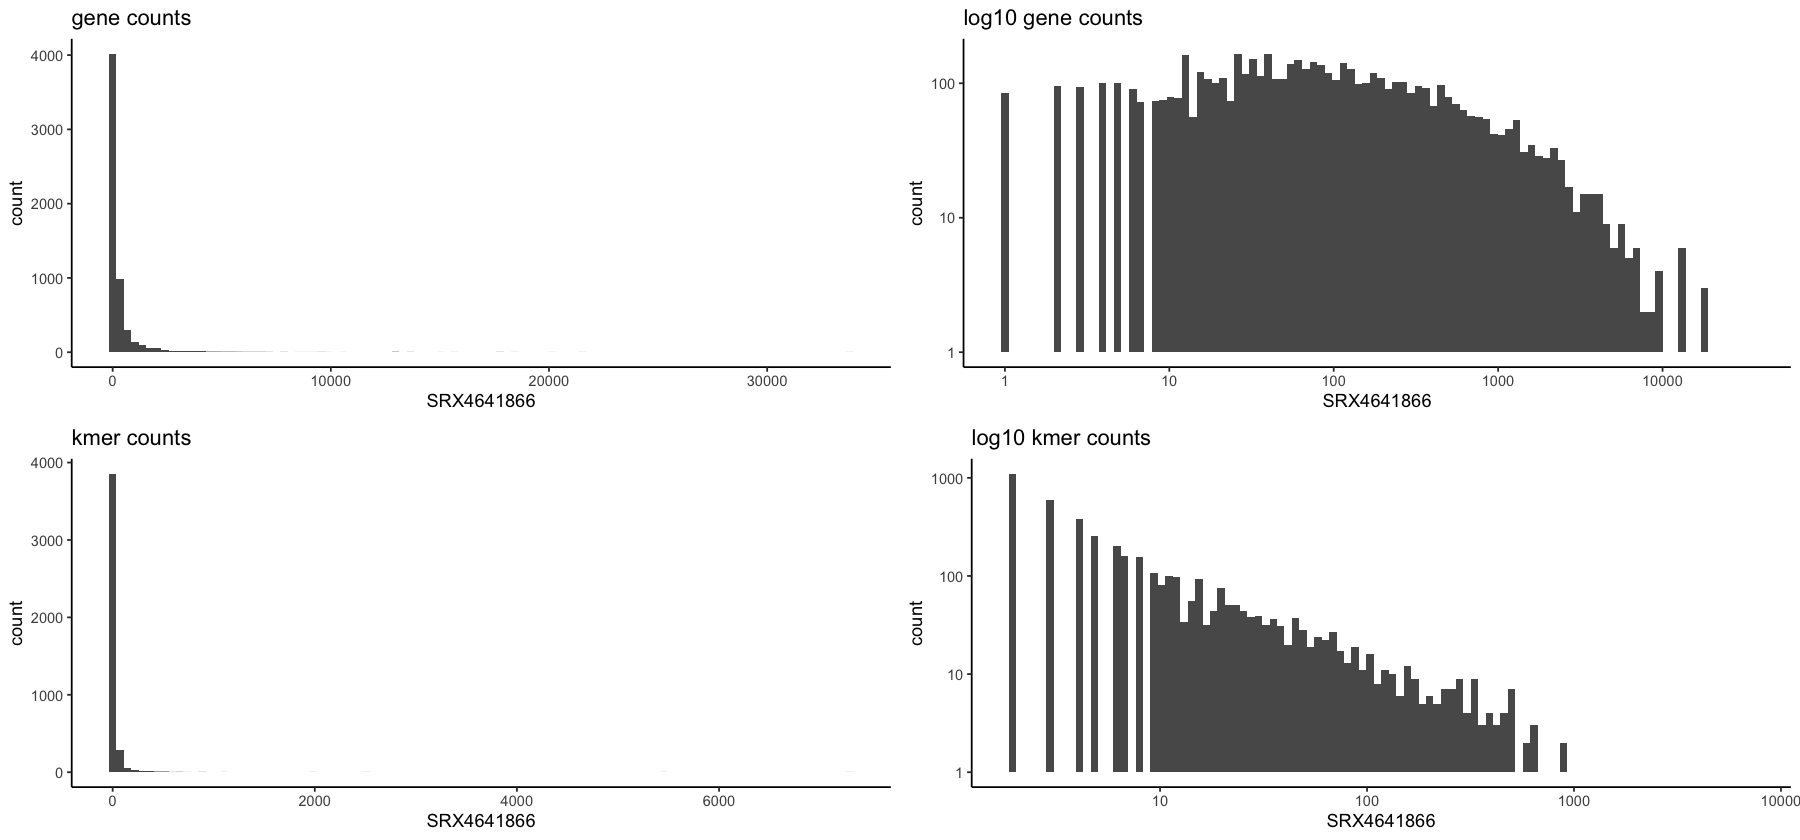

In [12]:
# because there are so many unobserved k-mers (0-count from combining with other k-mer counts),
# filter out zero counts for both k-mers and genes before looking at distributions via plotting

plt1 <- ggplot(raw_pa14_filt %>% filter(SRX4641866 > 0), aes(x = SRX4641866)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "gene counts")

plt2 <- ggplot(raw_pa14_filt %>% filter(SRX4641866 > 0), aes(x = SRX4641866)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 gene counts")

plt3 <- ggplot(raw_pa14_kmers %>% filter(SRX4641866 > 0), aes(x = SRX4641866)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt4 <- ggplot(raw_pa14_kmers %>% filter(SRX4641866 > 0), aes(x = SRX4641866)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2, plt3, plt4, nrow = 2, ncol = 2)

### Plot: example SRX1740205

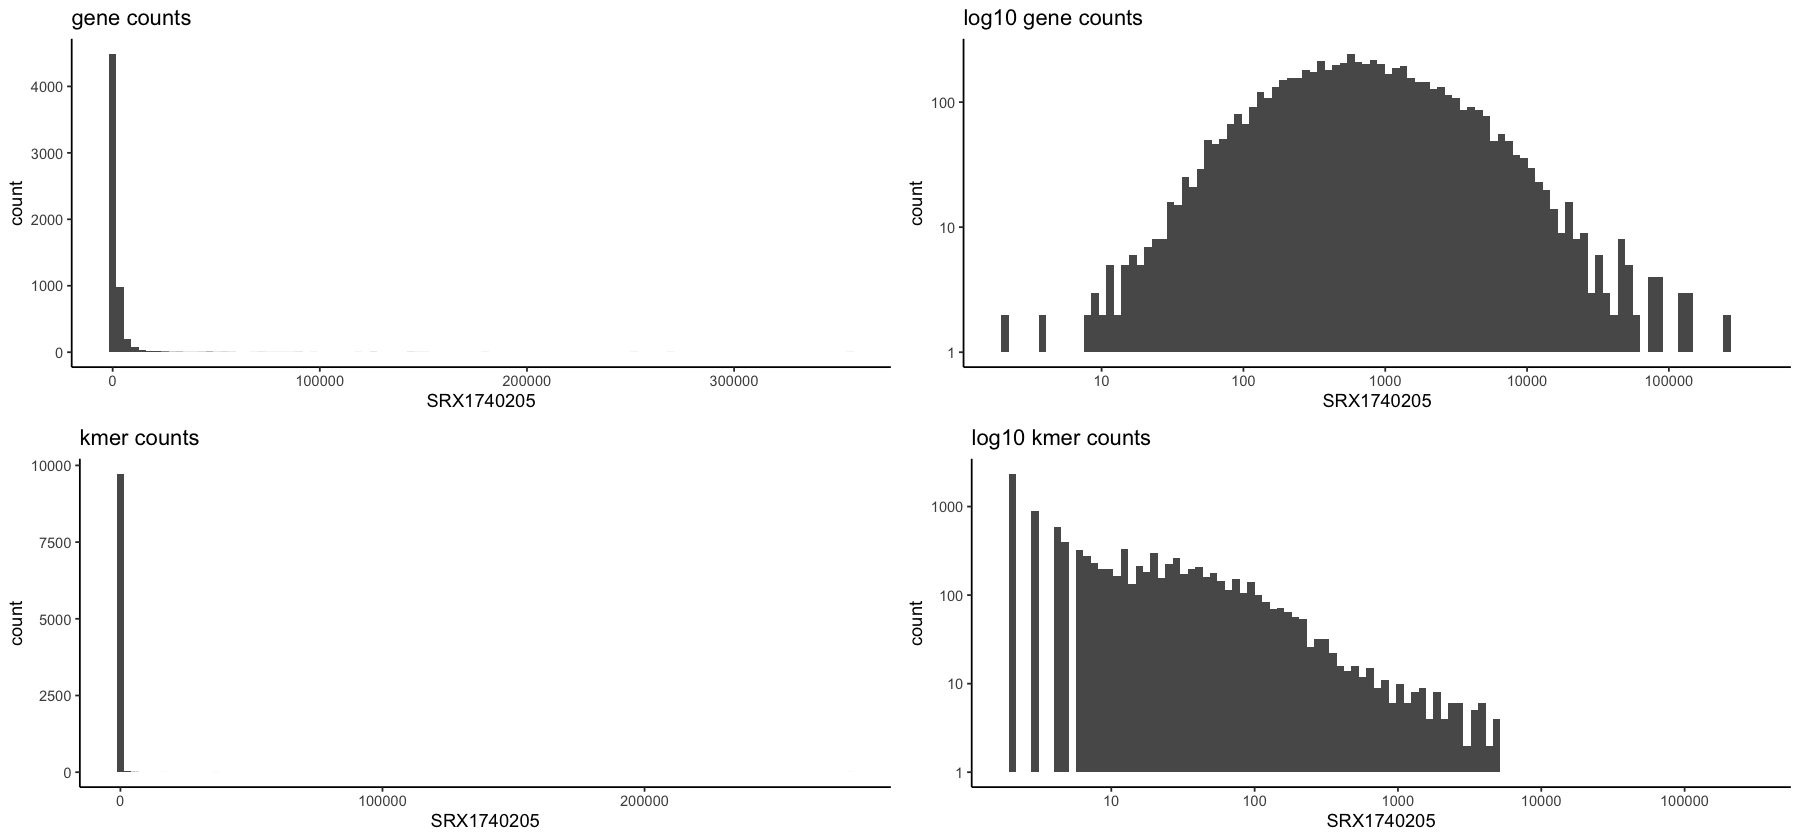

In [13]:
# because there are so many unobserved k-mers (0-count from combining with other k-mer counts),
# filter out zero counts for both k-mers and genes before looking at distributions via plotting

plt1 <- ggplot(raw_pa14_filt %>% filter(SRX1740205 > 0), aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "gene counts")

plt2 <- ggplot(raw_pa14_filt %>% filter(SRX1740205 > 0), aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 gene counts")

plt3 <- ggplot(raw_pa14_kmers %>% filter(SRX1740205 > 0), aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt4 <- ggplot(raw_pa14_kmers %>% filter(SRX1740205 > 0), aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2, plt3, plt4, nrow = 2, ncol = 2)

In [14]:
# perform a two-sample Kolmogorov-Smirnov test to test for differences in distributions
tmp1 <- raw_pa14_kmers %>% filter(SRX1740205 > 0)
tmp2 <- raw_pa14_filt %>% filter(SRX1740205 > 0)
ks.test(tmp1$SRX1740205, tmp2$SRX1740205)


	Two-sample Kolmogorov-Smirnov test

data:  tmp1$SRX1740205 and tmp2$SRX1740205
D = 0.83955, p-value < 0.00000000000000022
alternative hypothesis: two-sided


### Plot: example SRX9024460

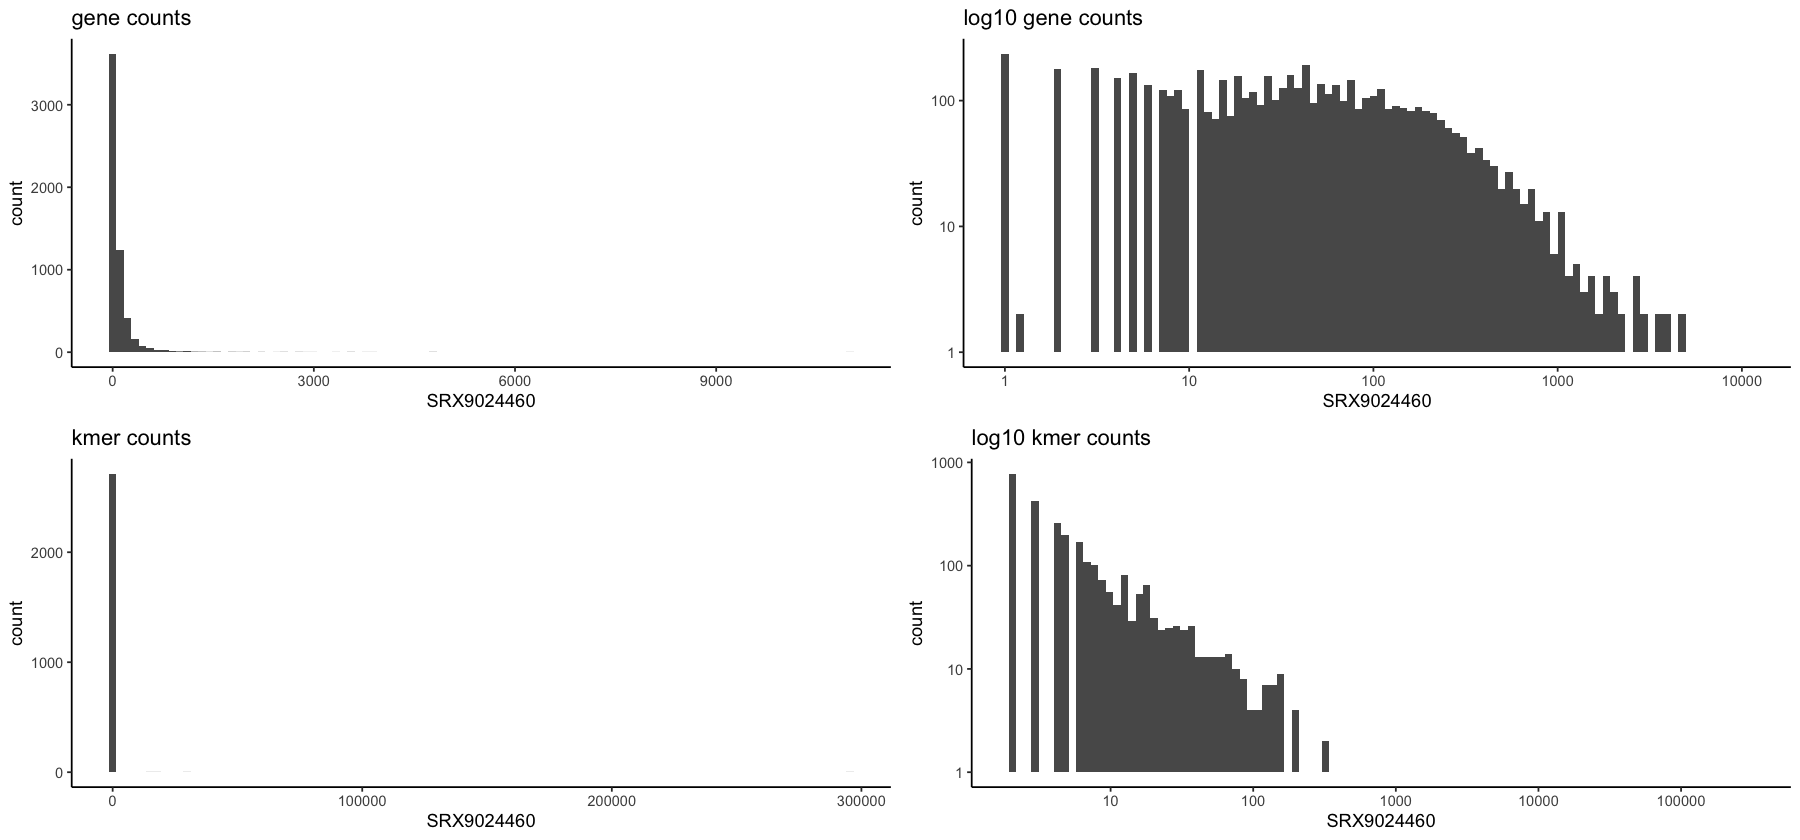

In [15]:
# because there are so many unobserved k-mers (0-count from combining with other k-mer counts),
# filter out zero counts for both k-mers and genes before looking at distributions via plotting

plt1 <- ggplot(raw_pa14_filt %>% filter(SRX9024460 > 0), aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "gene counts")

plt2 <- ggplot(raw_pa14_filt %>% filter(SRX9024460 > 0), aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 gene counts")

plt3 <- ggplot(raw_pa14_kmers %>% filter(SRX9024460 > 0), aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt4 <- ggplot(raw_pa14_kmers %>% filter(SRX9024460 > 0), aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2, plt3, plt4, nrow = 2, ncol = 2)

## plot: example pao1 SRX3573046

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


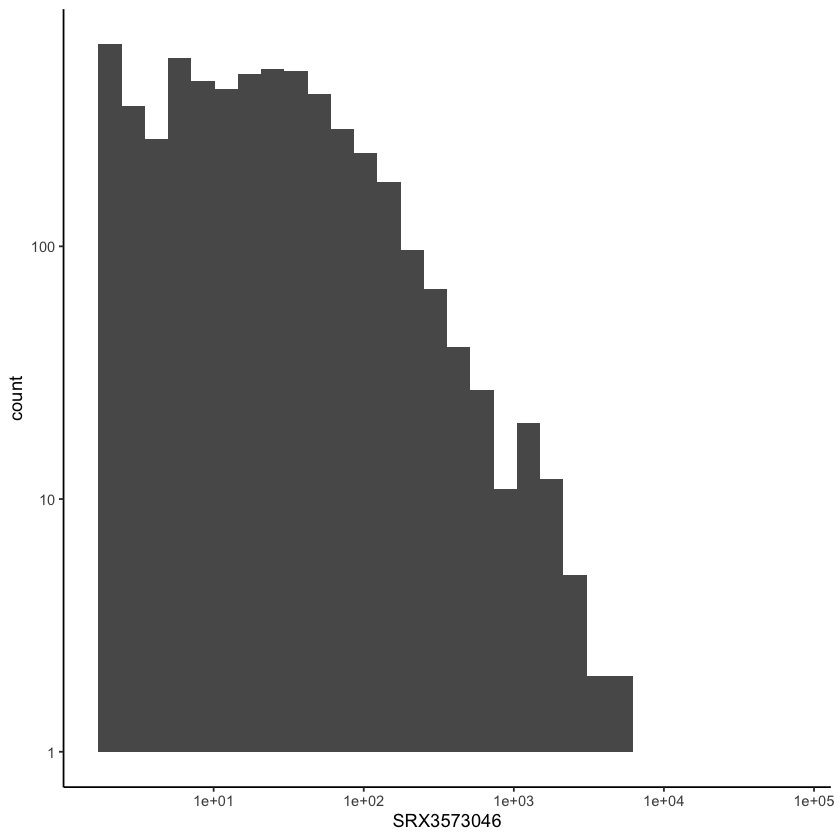

In [74]:
ggplot(tmp2 %>% filter(SRX3573046 > 1), aes(x = SRX3573046)) + 
  geom_histogram() +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10()

## Test for distribution identities

In [16]:
gene_SRX4641866 <- raw_pa14_filt %>% 
  filter(SRX4641866 > 0) %>%               # match k-mers by removing zero count genes
  dplyr::select(SRX4641866) %>%
  mutate(SRX4641866 = ceiling(SRX4641866)) # round up to nearest integer to restore count format

dist_gene_SRX4641866 <- fitDist(gene_SRX4641866$SRX4641866, k = 2, type = "counts", trace = FALSE, try.gamlss = TRUE)

summary(dist_gene_SRX4641866)

  |====================                                                  |  28%Error in solve.default(oout$hessian) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0
  |====================================================================  |  97%Error in solve.default(oout$hessian) : 
  Lapack routine dgesv: system is exactly singular: U[4,4] = 0
  |======================================================================| 100%
*******************************************************************
Family:  c("GPO", "Generalised Poisson") 

Call:  gamlssML(formula = y, family = DIST[i]) 

Fitting method: "nlminb" 


Coefficient(s):
            Estimate  Std. Error  t value               Pr(>|t|)    
eta.mu     5.8429616   0.0429325  136.097 < 0.000000000000000222 ***
eta.sigma -1.7507846   0.0110455 -158.507 < 0.000000000000000222 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Degrees of Freedom for the fit: 2 Residual Deg. of Freedom   5828 
Global De

Result: Family:  c("GPO", "Generalised Poisson")  (note it's generally agreed that gene counts have a negative binomial distribution)

In [17]:
kmer_SRX4641866 <- raw_pa14_kmers %>% 
  filter(SRX4641866 > 0) %>%               # match k-mers by removing zero count genes
  dplyr::select(SRX4641866) 

dist_kmer_SRX4641866 <- fitDist(kmer_SRX4641866$SRX4641866, k = 2, type = "counts", trace = FALSE, try.gamlss = TRUE)

summary(dist_kmer_SRX4641866)

  |====================                                                  |  28%Error in solve.default(oout$hessian) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0
  |======================================================================| 100%
*******************************************************************
Family:  c("DEL", "Delaporte") 

Call:  gamlssML(formula = y, family = DIST[i]) 

Fitting method: "nlminb" 


Coefficient(s):
            Estimate  Std. Error  t value               Pr(>|t|)    
eta.mu     3.1451545   0.0373589  84.1875 < 0.000000000000000222 ***
eta.sigma  2.0860310   0.0337645  61.7818 < 0.000000000000000222 ***
eta.nu    -1.8017643   0.0465568 -38.7003 < 0.000000000000000222 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Degrees of Freedom for the fit: 3 Residual Deg. of Freedom   4279 
Global Deviance:     29550.7 
            AIC:     29556.7 
            SBC:     29575.8 


Result: Family:  c("DEL", "Delaporte") 

In [18]:
dist_kmer_SRX4641866_0s <- fitDist(raw_pa14_kmers$SRX4641866, k = 2, type = "counts", trace = FALSE, try.gamlss = TRUE)

summary(dist_kmer_SRX4641866_0s)

  |====================                                                  |  28%Error in solve.default(oout$hessian) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0
  |======================================================================| 100%
*******************************************************************
Family:  c("ZIPIG", "Zero inflated Poisson inverse Gaussian") 

Call:  gamlssML(formula = y, family = DIST[i]) 

Fitting method: "nlminb" 


Coefficient(s):
           Estimate  Std. Error  t value               Pr(>|t|)    
eta.mu    3.0447391   0.0384400  79.2075 < 0.000000000000000222 ***
eta.sigma 1.9120914   0.0496039  38.5472 < 0.000000000000000222 ***
eta.nu    5.6863815   0.0159209 357.1640 < 0.000000000000000222 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 Degrees of Freedom for the fit: 3 Residual Deg. of Freedom   1400527 
Global Deviance:     87890.2 
            AIC:     87896.2 
            SBC:     87932.7 


Result: Family:  c("ZIPIG", "Zero inflated Poisson inverse Gaussian") 

## Try filtering k-mers that are only in one sample

k-mers that are in only one sample won't contain information that is useful for comparing againast other samples. 
for something so commonly sequenced as the data we're dealing with here, I expect many of these k-mers are errors, even if they occurr multiple times. 

In [28]:
# create a presence absence dataframe of k-mers, where 1 = present, 0 = absent.
# sum across rows. create an index of k-mers (hashes) that are only present in one sample
# filter these k-mers out, and then make distribution plots
raw_pa14_kmers_pa <- raw_pa14_kmers %>%
  column_to_rownames("minhash") %>%
  mutate_if(is.numeric, ~1 * (. != 0))

In [52]:
table(rowSums(raw_pa14_kmers_pa) > 10)


 FALSE   TRUE 
678334  11300 

In [53]:
keep_kmers <- rownames(raw_pa14_kmers_pa)[rowSums(raw_pa14_kmers_pa) > 10]

In [54]:
raw_pa14_kmers_filt <- raw_pa14_kmers %>%
  filter(minhash %in% keep_kmers)

In [55]:
dim(raw_pa14_kmers)
dim(raw_pa14_kmers_filt)

[1] 689634    101

[1] 11300   101

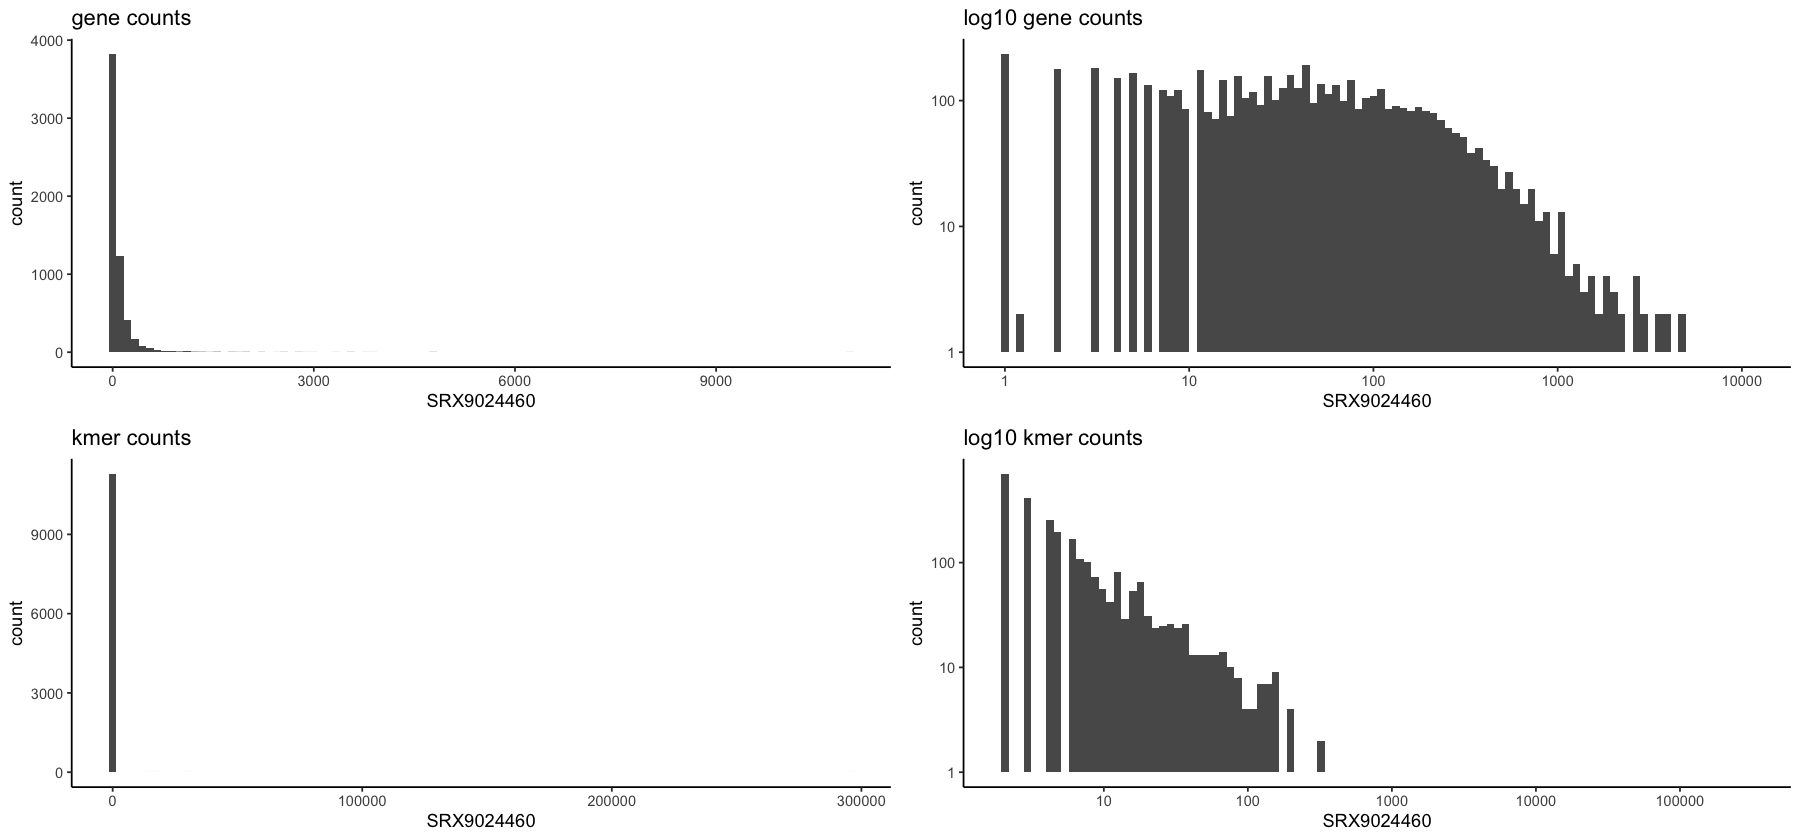

In [56]:
# after filtering kmers that are only in one sample, zeros are now probably real zeros so keep them

plt1 <- ggplot(raw_pa14_filt, aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "gene counts")

plt2 <- ggplot(raw_pa14_filt, aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 gene counts")

plt3 <- ggplot(raw_pa14_kmers_filt, aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt4 <- ggplot(raw_pa14_kmers_filt, aes(x = SRX9024460)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2, plt3, plt4, nrow = 2, ncol = 2)

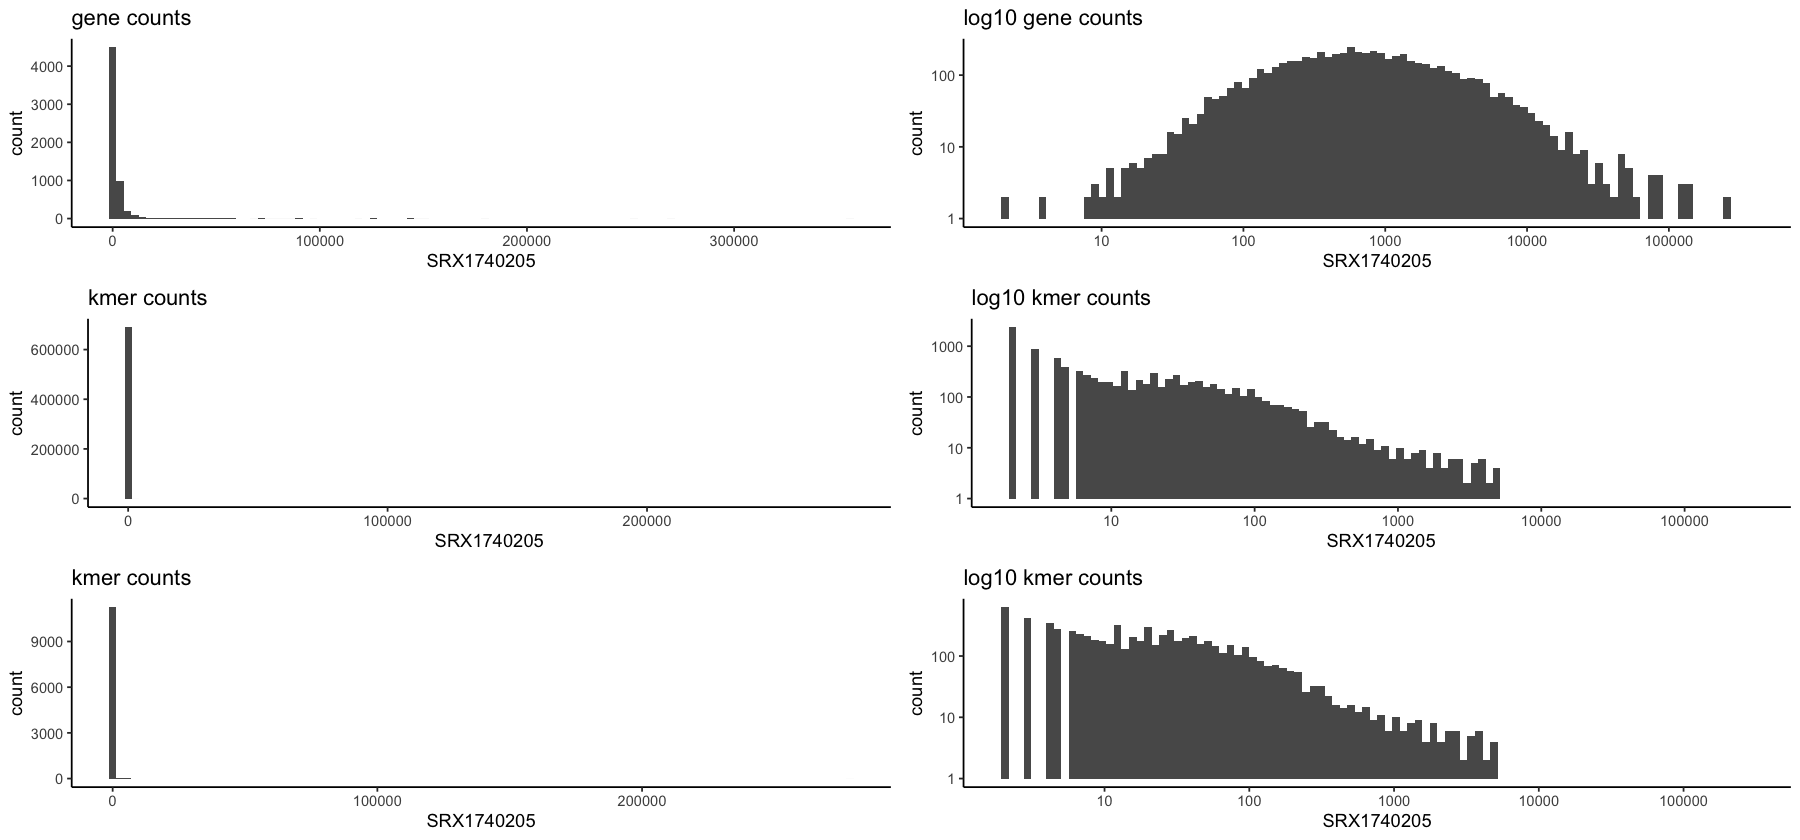

In [63]:
plt1 <- ggplot(raw_pa14_filt, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "gene counts")

plt2 <- ggplot(raw_pa14_filt, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 gene counts")

plt3 <- ggplot(raw_pa14_kmers, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt4 <- ggplot(raw_pa14_kmers, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

plt5 <- ggplot(raw_pa14_kmers_filt, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt6 <- ggplot(raw_pa14_kmers_filt, aes(x = SRX1740205)) + 
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2, plt3, plt4, plt5, plt6, nrow = 3, ncol = 2)

Look at the above panel. The middle panel plots the distribution without extra filtering, except where k-mer abund == 1. The bottom panel plots the distribution of k-mers that were only in multiple samples. In this case, it only plots the abundance of k-mers that were in 10 or more samples (out of starting 100). I made these plots using k-mers that were only in 2, 3, 4, ..., 10, samples, and the distribution shape didn't change, although the magnitude on the y axis shrank. E.g., even with intense filtering, the distribution shape doesn't really change.

By limiting to k-mers that were in at least 10 samples, it almost guarantees that we are only seeing real k-mers,  not k-mers that are generated by errors in sequencing. This means that k-mer abundance distributions are just kinda funky, and are different from genes abundances.

## Look at distribution for a random library, using only reads that mapped against the genome

Note that this wasn't a Pa transcriptome, it was just from a random transcriptome that I had laying around (ERX4307280; *Faecalibacterium prausnitzii* A2-165) that was mapped against GCF_010509575.1 using STAR. 

In [8]:
tmp <- read_csv("~/github/2022-microberna/sandbox/make_kmer_dist_mapped_reads/mapped_filt.csv", show_col_types = F)

In [9]:
head(tmp)

minhash,mapped_filt.sig
<dbl>,<dbl>
7841131971758,23
8967198976787,3
9391707097483,17
9516075586900,3
10719575467127,34
18577359249556,2


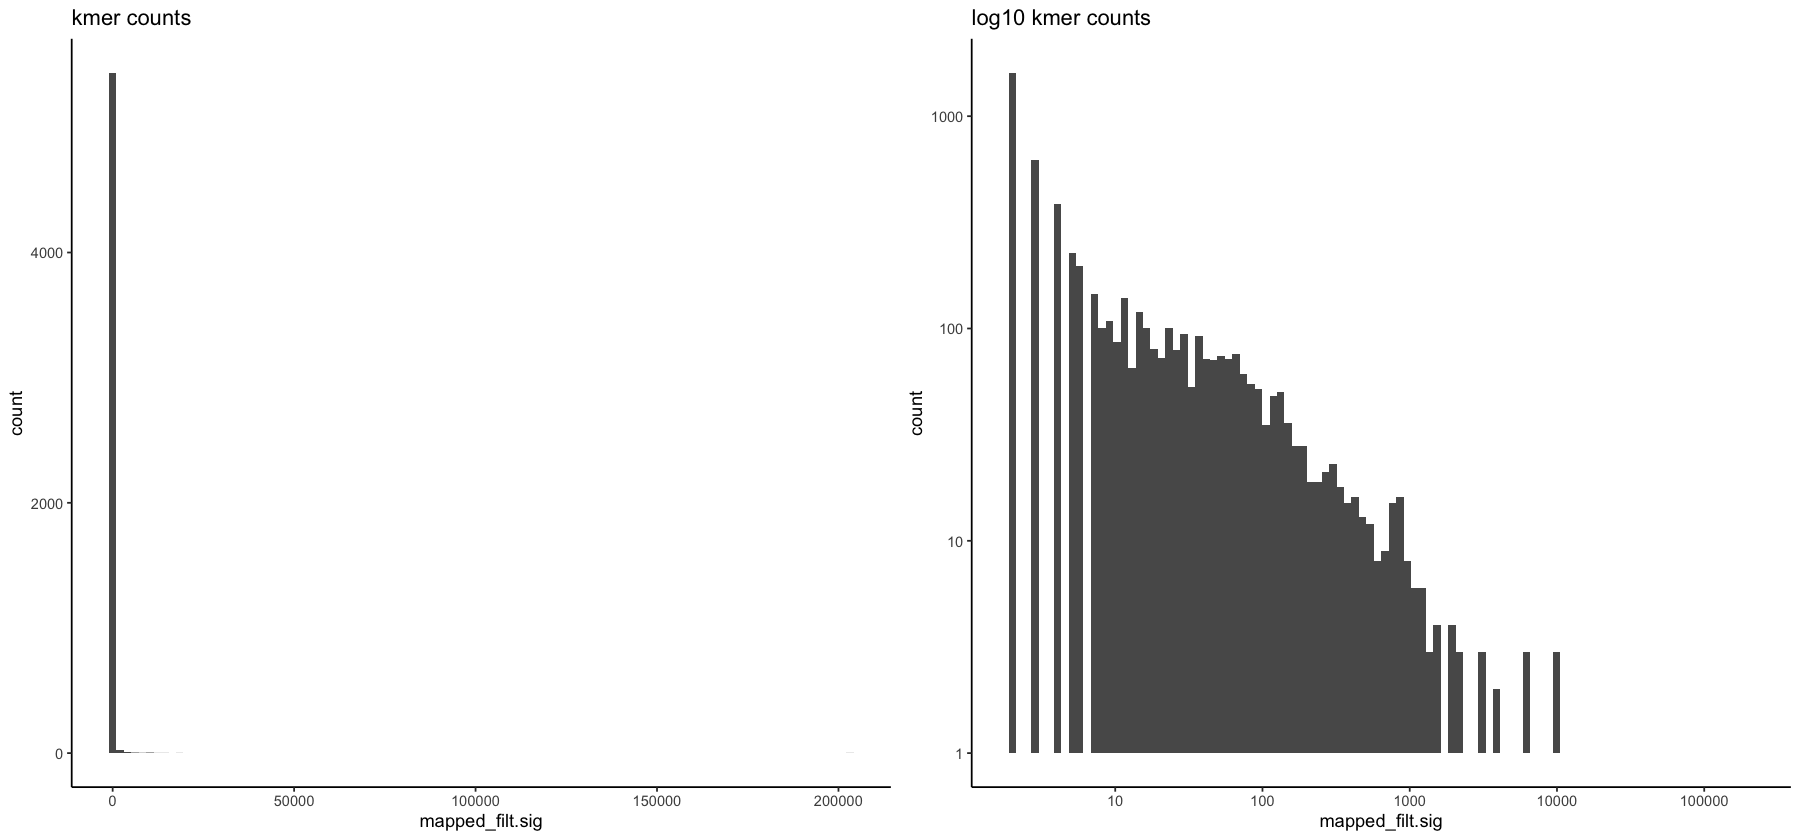

In [10]:
plt1 <- ggplot(tmp, aes(x = mapped_filt.sig)) +
  geom_histogram(bins = 100) +
  theme_classic()+
  labs(title = "kmer counts")

plt2 <- ggplot(tmp, aes(x = mapped_filt.sig)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  labs(title = "log10 kmer counts")

ggarrange(plt1, plt2)

## Conclusion

k-mer abundance distributions for transcriptomes are weird.